In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [4]:
from brian2 import *    # type: ignore

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [5]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [6]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

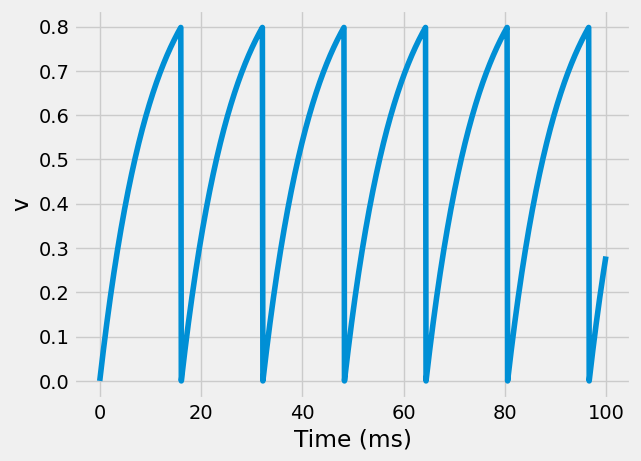

In [7]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

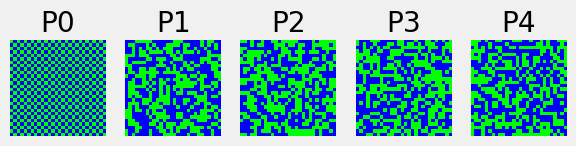

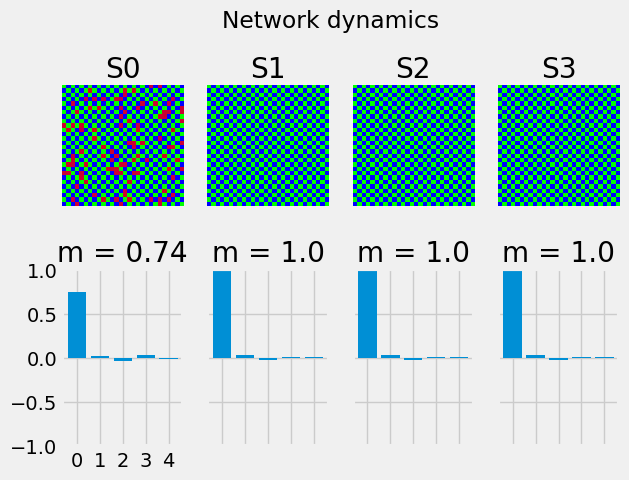

In [8]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools # type: ignore

pattern_size = 28

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=100)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

In [9]:
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Questions we answer using this notebook 

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Q1 
## Implementing the functions used in code

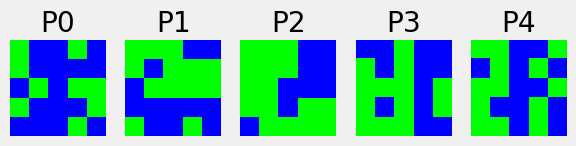

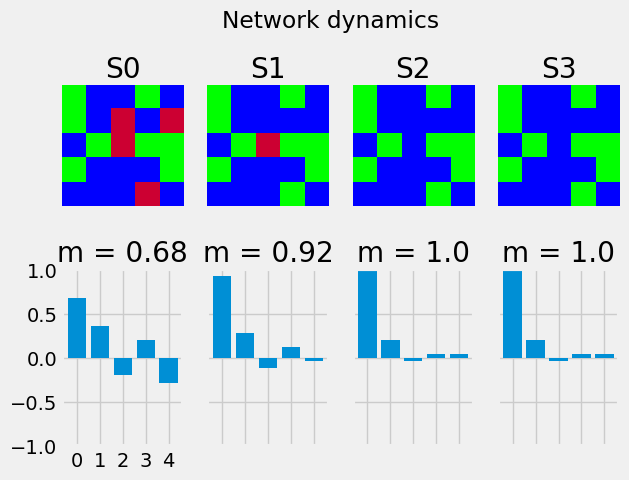

In [20]:
# Question 1-> 

def get_patterns(pattern_size,number_of_patterns) :
    # We use np.random.choice to generate the given number of patterns
    pattern_list=[np.random.choice([-1,1],size=(pattern_size,pattern_size)) for i in range(0,number_of_patterns,1)] 
    return pattern_list

def perturb_pattern(pattern2D, number_of_flips) :
    # We would choose random positions to flip the bits which can be done using np.random.choice again.
    pattern1D = pattern2D.flatten()
    flip_positions= np.random.choice(len(pattern1D),number_of_flips,False,None)
    pattern1D[flip_positions] *= -1
    perturbed_pattern = pattern1D.reshape(pattern2D.shape)
    return perturbed_pattern

def calculate_weights(pattern_list, pattern_size) : 
    N = pattern_size*pattern_size
    W = np.zeros((N,N))
    for u in range(0,len(pattern_list),1):
        pattern1D=pattern_list[u].flatten()
        W+=np.outer(pattern1D,pattern1D) # Nx1 into 1xN = NxN matrix
    
    # Constant 'c' in our assignment is chosen to be 1/N in formula
    W/=N;
    

    return W

def network_evolution(pattern,W):
    S=pattern.flatten()
    Sum=np.dot(W,S)
    # Take signum function over the Sum vector as mentioned in formula
    Sprime=np.sign(Sum)
    # If a sum was zero then we must change it to either -1 or 1, so we take it 1
    Sprime=np.where(Sprime ==0 , 1, Sprime)
    return Sprime.reshape(pattern.shape)
    
    
pattern_size=5
number_of_patterns=5
number_of_flips=4


plist = get_patterns(pattern_size,number_of_patterns)
# plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)
# print(cue[0])

S = perturb_pattern(cue[0],number_of_flips)
# plot_tools.plot_pattern(S)

wghts = calculate_weights(plist,pattern_size)
# print(wghts)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    S=network_evolution(S,wghts)
    state_list.append(S)
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
# plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

# Q2
## Plotting how ability to retrieve correct pattern is affected on changing different parameters

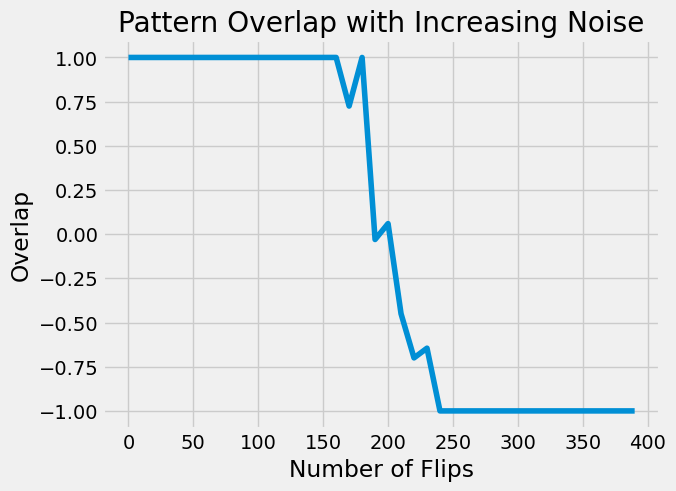

In [21]:
# Question 2->

# A) First we keep network size and number of patterns as constant
pattern_size=20
number_of_patterns=5
cue_number=0

overlap=[]
flips=[]
for nflips in range(0,400,10):
    plist = get_patterns(pattern_size,number_of_patterns)
    wghts = calculate_weights(plist,pattern_size)
    flips.append(nflips)
    cue = deepcopy(plist)
    S = perturb_pattern(cue[cue_number],nflips)
    state_list =[S]
    for i in range(3):
        S=network_evolution(S,wghts)
        state_list.append(S)
    # plot_tools.plot_pattern_list(state_list)
        
    final_evolved_pattern=state_list[-1]
    overlap_matrix =pattern_tools.compute_overlap_list(final_evolved_pattern, plist)
    overlap.append(overlap_matrix[cue_number])

plt.plot(flips,overlap)
plt.xlabel('Number of Flips')
plt.ylabel('Overlap')
plt.title(f'Pattern Overlap with Increasing Noise')
plt.show()
    
    
    



We observe that as the informativeness of the cue decreases, as the number of flips increases, the
ability of Network to retrieve correctly decreases as the overlap with the original pattern decreases.

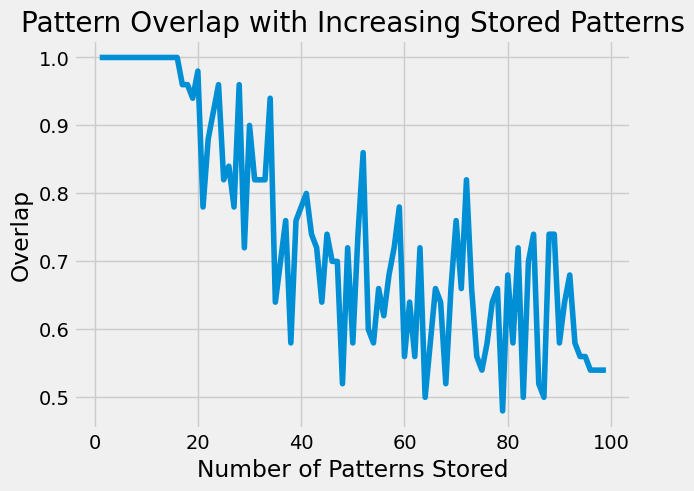

In [24]:
# Question 2->

# B) First we keep number of flips and network size  as constant

pattern_size=10
nflips=20;
cue_number=0

overlap=[]
nsizes=[]

for number_of_patterns in range(1,100,1):

    plist = get_patterns(pattern_size,number_of_patterns)
    wghts = calculate_weights(plist,pattern_size)
    nsizes.append(number_of_patterns)
    cue = deepcopy(plist)
    S = perturb_pattern(cue[cue_number],nflips)
    state_list =[S]
    for i in range(3):
        S=network_evolution(S,wghts)
        state_list.append(S)
    # plot_tools.plot_pattern_list(state_list)
        
    final_evolved_pattern=state_list[-1]
    overlap_matrix =pattern_tools.compute_overlap_list(final_evolved_pattern, plist)
    overlap.append(overlap_matrix[cue_number])

plt.plot(nsizes,overlap)
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Overlap')
plt.title(f'Pattern Overlap with Increasing Stored Patterns')
plt.show()
    
    
    



We observe that as the Number of patterns stored increases from 1 to 100, the ability of Network to
retrieve correctly decreases as the overlap with the original pattern decreases due to interference

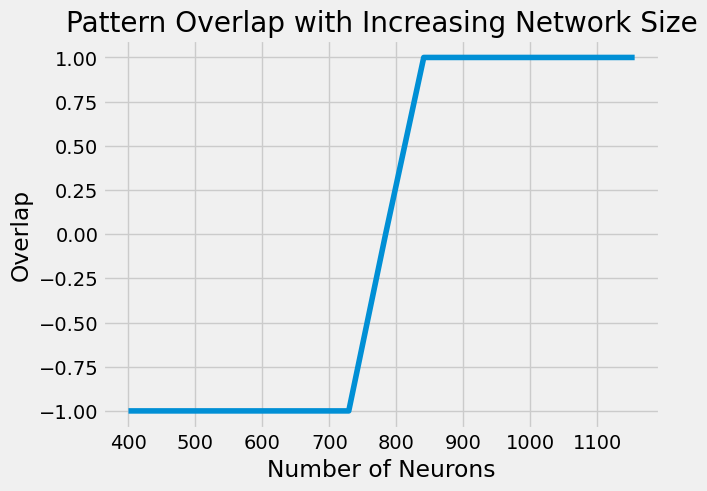

In [26]:
# Question 2->

# C) First we keep number of flips and number of patterns stored as constant
number_of_patterns=5
nflips=400;
cue_number=0


overlap=[]
nsizes=[]

for pattern_size in range(20,35,1):
    
    plist = get_patterns(pattern_size,number_of_patterns)
    wghts = calculate_weights(plist,pattern_size)
    nsizes.append(pattern_size**2)
    cue = deepcopy(plist)
    S = perturb_pattern(cue[cue_number],nflips)
    state_list =[S]
    for i in range(3):
        S=network_evolution(S,wghts)
        state_list.append(S)
    # plot_tools.plot_pattern_list(state_list)
        
    final_evolved_pattern=state_list[-1]
    overlap_matrix =pattern_tools.compute_overlap_list(final_evolved_pattern, plist)
    overlap.append(overlap_matrix[cue_number])

plt.plot(nsizes,overlap)
plt.xlabel('Number of Neurons')
plt.ylabel('Overlap')
plt.title(f'Pattern Overlap with Increasing Network Size')
plt.show()
    
    
    



We observe that as the Network Size( = Number of Neurons ) increase, the ability of Network to
retrieve correctly increases as the overlap with the original pattern increases.

# Q3 and Q4
## Implementing Converter function and Basic hopfield classifier


In [25]:
from tensorflow.keras.datasets import mnist
# Question 3->

def converter(image):
    # Since images entries lie in range of intensities [0, 255] we assume threshold as (0+255)/2
    threshold = 127
    pattern = np.where(image > threshold, 1, -1)
    # print(pattern)
    return pattern


28


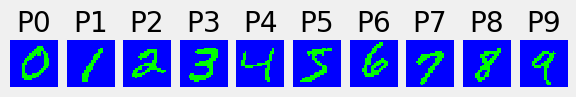

Accuracy of the Hopfield network on 10000 test samples: 9.74%
F1-score of the Hopfield network on 10000 test samples:-> 0.02


In [27]:
# Question 4->

from sklearn.metrics import f1_score 

class Our_Hopfield_Network :
    
    def get_patterns(pattern_size,number_of_patterns) :
        pattern_list=[np.random.choice([-1,1],size=(pattern_size,pattern_size)) for i in range(0,number_of_patterns,1)] 
        return pattern_list

    def perturb_pattern(pattern2D,number_of_flips) :
        pattern1D = pattern2D.flatten()
        flip_positions= np.random.choice(len(pattern1D), number_of_flips, False, None)
        pattern1D[flip_positions] *= -1
        perturbed_pattern = pattern1D.reshape(pattern2D.shape)
        return perturbed_pattern

    def calculate_weights(pattern_list, pattern_size) : 
        N = pattern_size*pattern_size
        W = np.zeros((N,N))
        for u in range(0,len(pattern_list),1):
            pattern1D=pattern_list[u].flatten()
            W+=np.outer(pattern1D,pattern1D) # Nx1 into 1xN = NxN matrix
    
        W/=N;

        return W

    def network_evolution(pattern,W):
        S=pattern.flatten()
        Sum=np.dot(W,S)
        # Take signum function over the Sum vector as mentioned in formula
        Sprime=np.sign(Sum)
        # If a sum was zero then we must change it to either -1 or 1, so we take it 1/
        Sprime=np.where(Sprime ==0 , 1, Sprime)

        return Sprime.reshape(pattern.shape)
    

def converter(image):
    # Since images entries lie in range of intensities [0, 255] we assume threshold as (0+255)/2
    threshold = 127
    pattern = np.where(image > threshold, 1, -1)
    # print(pattern)
    return pattern

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
mnist_image = train_images[0]
# print(train_label[0]) --> 5 
# print(mnist_image.shape) --> 28 * 28 , so we will create our patterns of 28x28  
pattern_size= train_images[0].shape[0]
print(pattern_size)

# Type in here the digits you want to put in your training data
train_digits = [0,1,2,3,4,5,6,7,8,9]
plist = []

# We fill in the first image of each digit
for digit in train_digits:
    for i in range(0,len(train_labels),1):
        if train_labels[i]==digit:
            plist.append(converter(train_images[i]))
            break

plot_tools.plot_pattern_list(plist)
weights = Our_Hopfield_Network.calculate_weights(plist,pattern_size)

# We evaluate the model on a subset of test data

num_test_samples =10000

correct_predictions =0
label_true=[]
label_predicted=[]
for i in range(num_test_samples):
    test_image = converter(test_images[i])
    test_label = test_labels[i]
    label_true.append(test_label)
    state_list = [test_image]

    niter =30
    for j in range(niter):
        evolved_state = Our_Hopfield_Network.network_evolution(state_list[-1], weights)
        state_list.append(evolved_state)
    
    # plot_tools.plot_pattern_list(state_list)
    # We compute the overlap of our evolved pattern with each of the patterns in plist to find overlap
    final_evolved_pattern=state_list[-1]
    overlap_matrix =pattern_tools.compute_overlap_list(final_evolved_pattern, plist)
    
    # We then find the pattern with the maximum overlap and return its label as predicted label
    max_index = np.argmax(overlap_matrix)
    # Predict the label
    predicted_label = train_digits[max_index]
    label_predicted.append(predicted_label)
    
    if predicted_label == test_label:
        correct_predictions += 1


accuracy = correct_predictions / num_test_samples * 100
print(f"Accuracy of the Hopfield network on {num_test_samples} test samples: {accuracy:.2f}%")
# Calculate F1 score
f1 = f1_score(label_true, label_predicted, average='weighted')
print(f"F1-score of the Hopfield network on {num_test_samples} test samples:-> {f1:.2f}")
  

# Q4)

### Enhanced Version of Hopfield Classifier using Storkey Learning

We use the Storkey Learning Rule to increase the number of patterns which can be stored instead of Basic Hebbian Rule.

$$\Delta w_{ij}^\mu = \frac{1}{N} \left( \xi_i^\mu \xi_j^\mu - \xi_i^\mu h_j^\mu - \xi_j^\mu h_i^\mu \right)$$


We will also use De-skewing of the images to remove tilts which lead to wrong classification at the same time, we will resize the images to 14x14.

We will also crop the images to store only the patterns as it is, removing the black borders around the MNIST data.

Taking multiple samples of the same digit will lead to decrease in performance so we keep one image per digit in training our model


In [28]:
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools # type: ignore
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets import mnist
import skimage
import cv2 

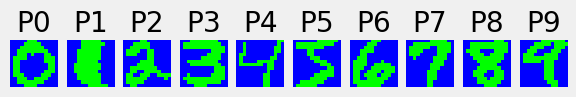


Overall Classification Results are as follows:
F1-Score for our model: 0.587
Accuracy for our model: 51.590%

Classification results per digit:


Digit 0:
Correct answers:95.10%
Incorrect ansers:2.65%
Spurious answers:2.24%


Digit 1:
Correct answers:71.19%
Incorrect ansers:17.53%
Spurious answers:11.28%


Digit 2:
Correct answers:34.11%
Incorrect ansers:51.07%
Spurious answers:14.83%


Digit 3:
Correct answers:40.40%
Incorrect ansers:23.27%
Spurious answers:36.34%


Digit 4:
Correct answers:21.59%
Incorrect ansers:74.54%
Spurious answers:3.87%


Digit 5:
Correct answers:10.20%
Incorrect ansers:65.36%
Spurious answers:24.44%


Digit 6:
Correct answers:86.33%
Incorrect ansers:10.96%
Spurious answers:2.71%


Digit 7:
Correct answers:20.53%
Incorrect ansers:33.07%
Spurious answers:46.40%


Digit 8:
Correct answers:56.06%
Incorrect ansers:26.18%
Spurious answers:17.76%


Digit 9:
Correct answers:76.51%
Incorrect ansers:8.33%
Spurious answers:15.16%



In [29]:

class Our_Hopfield_Network:
    
    def get_patterns(pattern_size,number_of_patterns) :
        pattern_list=[np.random.choice([-1,1],size=(pattern_size,pattern_size)) for i in range(0,number_of_patterns,1)] 
        return pattern_list

    def perturb_pattern(pattern2D, number_of_flips) :
        pattern1D = pattern2D.flatten()
        flip_positions= np.random.choice(len(pattern1D), number_of_flips, False, None)
        pattern1D[flip_positions] *= -1
        perturbed_pattern = pattern1D.reshape(pattern2D.shape)
        return perturbed_pattern
    
    def network_evolution(pattern,W):
        S=pattern.flatten()
        Sum=np.dot(W,S)
        # We take signum function over the Sum vector as mentioned in formula
        Sprime=np.sign(Sum)
        Sprime=np.where(Sprime ==0 , 1, Sprime)
        return Sprime.reshape(pattern.shape)    
            
    def storkey_learning(pattern_list,pattern_size):
        N=pattern_size**2
        W=np.zeros((N, N))

        for pattern in pattern_list:
            pattern1D = pattern.flatten()
            for i in range(0,N,1):
                for j in range(0,N,1):
                    if i != j:
                        h_i = np.dot(W[i,:], pattern1D) -pattern1D[i]*W[i,i]
                        h_j = np.dot(W[j,:], pattern1D) -pattern1D[j]*W[j,j]
                        W[i, j]+=(pattern1D[i]*pattern1D[j]-pattern1D[i] *h_j-h_i*pattern1D[j])/N
                        
        return W

# We have changed our converter function in accordance with the paper.
def converter(image):
    deskewed_image=deskew(image)
    # print(deskewed_image)
    cropped_image =crop_image_to_digit(deskewed_image)
    # print(cropped_image)
    resized_image =skimage.transform.resize(cropped_image, (14, 14), anti_aliasing=True)
    # print(resized_image)
    resized_image_255 = (resized_image * 255).astype(np.uint8)
    # print(resized_image_255)
    # We use the threshold mentioned in the paper for 14x14 images to 86
    threshold =86
    return np.where(resized_image_255 >threshold,1,-1)

def crop_image_to_digit(image):
    # We find the non-zero pixels in the image as in deskewed image we found that borders are zeroes
    coords =np.argwhere(image >0)
    cropped_image=image
    # Then we find the bounding box of the non-zero pixels
    if coords.shape[0] > 0:
        x_min =coords.min(axis=0)[0]
        y_min =coords.min(axis=0)[1]
        x_max =coords.max(axis=0)[0]
        y_max =coords.max(axis=0)[1]
        cropped_image=image[x_min:x_max+1,y_min:y_max+1]
        
    return cropped_image

def deskew(image):
    # We find out the moments of the image and use them to correct the skew and offset in x direction
    m = cv2.moments(image)
    if abs(m["mu02"]) < 1e-2:
        return image
    
    skew =m["mu11"]/m["mu02"]
    x_offset=-0.5*image.shape[1]*skew
    M = np.float32([[1,skew,x_offset],[0,1,0]])
    deskewed_image = cv2.warpAffine(image, M,(image.shape[1],image.shape[0]),flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)
    return deskewed_image


# Load the MNIST dataset
(train_images, train_labels),(test_images,test_labels)=mnist.load_data()

# Type in here the digits you want to put in your training data
train_digits = [0,1,2,3,4,5,6,7,8,9]
plist = []

# We fill in the first image of each digit
for digit in train_digits:
    for i in range(0,len(train_labels),1):
        if train_labels[i]==digit:
            plist.append(converter(train_images[i]))
            break


plot_tools.plot_pattern_list(plist)
pattern_size = 14

weights =Our_Hopfield_Network.storkey_learning(plist,pattern_size)

# We create map like structure for each digit
digit_ans = {digit:{"correct":0,"incorrect":0,"spurious": 0} for digit in range(0,10,1)}
total_ans =0

y_true = []
y_hat = []
correct_ans =0
incorrect_ans =0
spurious_ans =0

for i in range(0,10000,1):
        test_image=converter(test_images[i])
        test_label=test_labels[i]
        # We evolve the states for 20 iterations each
        niterations =20
        state_list =[test_image]
        for j in range(0,niterations,1):
            evolved_state = Our_Hopfield_Network.network_evolution(state_list[-1],weights)
            state_list.append(evolved_state)
        # plot_tools.plot_pattern_list(state_list)
        
        # Now we compute the overlap of the evolved pattern with the training patterns
        final_evolved_pattern=state_list[-1]
        overlap_matrix = pattern_tools.compute_overlap_list(final_evolved_pattern, plist)
        y_true.append(test_label)
        y_hat.append(train_digits[np.argmax(overlap_matrix)])
        
        total_ans+=1
        
        
        if overlap_matrix[train_digits.index(test_label)] == 1:
            digit_ans[test_label]["correct"]+=1
            correct_ans += 1
        elif 1 in overlap_matrix:
            digit_ans[test_label]["incorrect"]+=1
            incorrect_ans += 1
        else:
            digit_ans[test_label]["spurious"]+=1
            spurious_ans += 1
            


accuracy = correct_ans / total_ans * 100
f1 = f1_score(y_true,y_hat, average='weighted')


print(f"\nOverall Classification Results are as follows:")
print(f"F1-Score for our model: {f1:.3f}")
print(f"Accuracy for our model: {accuracy:.3f}%")

# We print the classification results for each digit from 0 to 9
print("\nClassification results per digit:\n")
for digit in range(0,10,1):
    total_digit_ans=sum(list(digit_ans[digit].values()))
    correct_percentage =(digit_ans[digit]["correct"]/total_digit_ans)*100
    incorrect_percentage =(digit_ans[digit]["incorrect"]/total_digit_ans)*100
    spurious_percentage =(digit_ans[digit]["spurious"]/total_digit_ans)*100

    print(f"\nDigit {digit}:")
    print(f"Correct answers:{correct_percentage:.2f}%")
    print(f"Incorrect ansers:{incorrect_percentage:.2f}%")
    print(f"Spurious answers:{spurious_percentage:.2f}%\n")

# Q4)

### Enhanced Version of Hopfield Classifier using Pseudo Inverse Learning

We use the Pseudo Inverse Learning Rule to increase the number of patterns which can be stored instead of Basic Hebbian Rule.

$$W = X^{T} \left( X X^{T} \right)^{-1} X$$

Here I also implement the averaging of images for each digit 0 to 9

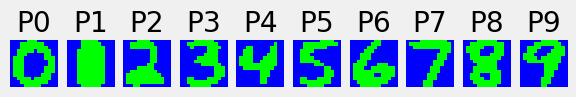


Overall Classification Results are as follows:
F1-Score for our model: 0.820
Accuracy for our model: 79.800%

Classification results per digit:


Digit 0:
Correct answers:95.20%
Incorrect ansers:2.35%
Spurious answers:2.45%


Digit 1:
Correct answers:93.48%
Incorrect ansers:3.17%
Spurious answers:3.35%


Digit 2:
Correct answers:73.93%
Incorrect ansers:16.67%
Spurious answers:9.40%


Digit 3:
Correct answers:85.25%
Incorrect ansers:9.01%
Spurious answers:5.74%


Digit 4:
Correct answers:72.10%
Incorrect ansers:19.45%
Spurious answers:8.45%


Digit 5:
Correct answers:67.26%
Incorrect ansers:20.07%
Spurious answers:12.67%


Digit 6:
Correct answers:85.70%
Incorrect ansers:6.26%
Spurious answers:8.04%


Digit 7:
Correct answers:87.06%
Incorrect ansers:9.73%
Spurious answers:3.21%


Digit 8:
Correct answers:62.83%
Incorrect ansers:30.08%
Spurious answers:7.08%


Digit 9:
Correct answers:71.95%
Incorrect ansers:23.89%
Spurious answers:4.16%



In [30]:
import numpy as np

class Our_Hopfield_Network:
    
    def get_patterns(pattern_size,number_of_patterns) :
        pattern_list=[np.random.choice([-1,1],size=(pattern_size,pattern_size)) for i in range(0,number_of_patterns,1)] 
        return pattern_list

    def perturb_pattern(pattern2D, number_of_flips) :
        pattern1D = pattern2D.flatten()
        flip_positions= np.random.choice(len(pattern1D), number_of_flips, False, None)
        pattern1D[flip_positions] *= -1
        perturbed_pattern = pattern1D.reshape(pattern2D.shape)
        return perturbed_pattern
    
    def network_evolution(pattern,W):
        S=pattern.flatten()
        Sum=np.dot(W,S)
        # We take signum function over the Sum vector as mentioned in formula
        Sprime=np.sign(Sum)
        Sprime=np.where(Sprime ==0 , 1, Sprime)
        return Sprime.reshape(pattern.shape)   

    def pseudo_inverse_learning(pattern_list):
        # First we create a mtrx of 10 x 196
        pattern2d= np.array([pattern.flatten() for pattern in pattern_list])
        # print(pattern2d.shape)
        middle=np.dot(pattern2d, pattern2d.T)
        # print(middle.shape)
        We = np.dot(pattern2d.T, np.dot(np.linalg.pinv(middle), pattern2d))
        # We make the self association as zero for better accuracy.
        np.fill_diagonal(We, 0)
        return We

# We have changed our converter function in accordance with the paper.
def converter(image):
    deskewed_image=deskew(image)
    # print(deskewed_image)
    cropped_image =crop_image_to_digit(deskewed_image)
    # print(cropped_image)
    resized_image =skimage.transform.resize(cropped_image, (14, 14), anti_aliasing=True)
    # print(resized_image)
    resized_image_255 = (resized_image * 255).astype(np.uint8)
    # print(resized_image_255)
    # We use the threshold mentioned in the paper for 14x14 images to 86
    threshold =86
    return np.where(resized_image_255 >threshold,1,-1)

def crop_image_to_digit(image):
    # We find the non-zero pixels in the image as in deskewed image we found that borders are zeroes
    coords =np.argwhere(image >0)
    cropped_image=image
    # Then we find the bounding box of the non-zero pixels
    if coords.shape[0] > 0:
        x_min =coords.min(axis=0)[0]
        y_min =coords.min(axis=0)[1]
        x_max =coords.max(axis=0)[0]
        y_max =coords.max(axis=0)[1]
        cropped_image=image[x_min:x_max+1,y_min:y_max+1]
        
    return cropped_image

def deskew(image):
    # We find out the moments of the image and use them to correct the skew and offset in x direction
    m = cv2.moments(image)
    if abs(m["mu02"]) < 1e-2:
        return image
    
    skew =m["mu11"]/m["mu02"]
    x_offset=-0.5*image.shape[1]*skew
    M = np.float32([[1,skew,x_offset],[0,1,0]])
    deskewed_image = cv2.warpAffine(image, M,(image.shape[1],image.shape[0]),flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)
    return deskewed_image

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# I average out the images in the training data to create a averaged image for each digit

average_patterns = []

for digit in train_digits:
    digit_images = []
    for i in range(len(train_labels)):
        if train_labels[i] == digit:
            digit_images.append(converter(train_images[i]))

    # Convert to np array, sum and average
    digit_images= np.array(digit_images)
    average_image =np.mean(digit_images,axis=0)
    
    # Convert the average image back to binary form
    average_image_binary =np.where(average_image > 0, 1, -1)
    average_patterns.append(average_image_binary)

plot_tools.plot_pattern_list(average_patterns)
pattern_size = 14

# Train the Hopfield network using pseudo-inverse learning on the averaged patterns
weights =Our_Hopfield_Network.pseudo_inverse_learning(average_patterns)



# We create map like structure for each digit
digit_ans = {digit:{"correct":0,"incorrect":0,"spurious": 0} for digit in range(0,10,1)}
total_ans =0

y_true = []
y_hat = []
correct_ans =0
incorrect_ans =0
spurious_ans =0

for i in range(0,10000,1):
        test_image=converter(test_images[i])
        test_label=test_labels[i]
        # We evolve the states for 20 iterations each
        niterations =20
        state_list =[test_image]
        for j in range(0,niterations,1):
            evolved_state = Our_Hopfield_Network.network_evolution(state_list[-1],weights)
            state_list.append(evolved_state)
        # plot_tools.plot_pattern_list(state_list)
        
        # Now we compute the overlap of the evolved pattern with the training patterns
        final_evolved_pattern=state_list[-1]
        overlap_matrix = pattern_tools.compute_overlap_list(final_evolved_pattern, average_patterns)
        # print(overlap_matrix)
        y_true.append(test_label)
        y_hat.append(train_digits[np.argmax(overlap_matrix)])
        
        total_ans+=1
        
        if overlap_matrix[train_digits.index(test_label)] == 1:
            digit_ans[test_label]["correct"]+=1
            correct_ans += 1
        elif 1 in overlap_matrix:
            digit_ans[test_label]["incorrect"]+=1
            incorrect_ans += 1
        else:
            digit_ans[test_label]["spurious"]+=1
            spurious_ans += 1
            
accuracy = correct_ans / total_ans * 100
f1 = f1_score(y_true,y_hat, average='weighted')

print(f"\nOverall Classification Results are as follows:")
print(f"F1-Score for our model: {f1:.3f}")
print(f"Accuracy for our model: {accuracy:.3f}%")

# We print the classification results for each digit from 0 to 9
print("\nClassification results per digit:\n")
for digit in range(0,10,1):
    total_digit_ans=np.sum(list(digit_ans[digit].values()))
    correct_percentage =(digit_ans[digit]["correct"]/total_digit_ans)*100
    incorrect_percentage =(digit_ans[digit]["incorrect"]/total_digit_ans)*100
    spurious_percentage =(digit_ans[digit]["spurious"]/total_digit_ans)*100

    print(f"\nDigit {digit}:")
    print(f"Correct answers:{correct_percentage:.2f}%")
    print(f"Incorrect ansers:{incorrect_percentage:.2f}%")
    print(f"Spurious answers:{spurious_percentage:.2f}%\n")

# RESULTS ::

- CNN deep learning Neural Network gave 99.61% of accuracy.
- Classical SVM model gave 98.52% of accuracy.
- Accuracy of the Hopfield network on 10000 test samples: 79.80% with 100% confidence

## BASIC HOPFIELD NETWORK USING HEBBIAN LEARNING
- Train the Network on all 10 digits
- Accuracy of the Hopfield network on 10000 test samples: 9.74%
- F1-score of the Hopfield network on 10000 test samples: -> 0.02

## ENHANCED HOPFIELD NETWORK USING STORKEY LEARNING
- Train the Network on all 10 digits
- Accuracy of the Hopfield network on 10000 test samples: 51.59%
- F1-score of the Hopfield network on 10000 test samples: -> 0.59

## ENHANCED HOPFIELD NETWORK USING PSEUDO INVERSE LEARNING
- Train the Network on all 10 digits
- Accuracy of the Hopfield network on 10000 test samples: 79.80%
- F1-score of the Hopfield network on 10000 test samples: -> 0.82%

# Classification results per digit:

## Digit 0:
- **Correct answers**: 95.20%
- **Incorrect answers**: 2.35%
- **Spurious answers**: 2.45%

## Digit 1:
- **Correct answers**: 93.48%
- **Incorrect answers**: 3.17%
- **Spurious answers**: 3.35%

## Digit 2:
- **Correct answers**: 73.93%
- **Incorrect answers**: 16.67%
- **Spurious answers**: 9.40%

## Digit 3:
- **Correct answers**: 85.25%
- **Incorrect answers**: 9.01%
- **Spurious answers**: 5.74%

## Digit 4:
- **Correct answers**: 72.10%
- **Incorrect answers**: 19.45%
- **Spurious answers**: 8.45%

## Digit 5:
- **Correct answers**: 67.26%
- **Incorrect answers**: 20.07%
- **Spurious answers**: 12.67%

## Digit 6:
- **Correct answers**: 85.70%
- **Incorrect answers**: 6.26%
- **Spurious answers**: 8.04%

## Digit 7:
- **Correct answers**: 87.06%
- **Incorrect answers**: 9.73%
- **Spurious answers**: 3.21%

## Digit 8:
- **Correct answers**: 62.83%
- **Incorrect answers**: 30.08%
- **Spurious answers**: 7.08%

## Digit 9:
- **Correct answers**: 71.95%
- **Incorrect answers**: 23.89%
- **Spurious answers**: 4.16%



### OBSERVATIONS

- #### Maximum accuracy of ~95% in classifying the digit '0' in 10,000 test samples.

- This shows that 0 and 1 are the attractor patterns for our network as they have the highest classification rate according to the training patterns we have put as input.

- Digit 4 and 8 results in high incorrect classification which is due to the above mentioned attractor patterns.

## MERITS of HOPFIELD NETWORK MODELS ::

Being based on concepts of associative memory, I note the following points as merits ->

- HopField Networks can act as great error detectors and correctors in the patterns which arealready stored in Network. So given a noisy pattern within a certain level of noise, we can get back the original pattern without noise.

- HopField Networks use basic learning architecture hence are very easy to implement as in ourcode. They can be also seen through energy pictures where each of the main minima correspond to pattern retrievals and local minimas which correspond to mixture of patterns.

- Enhancing the learning logic of the models and deskewing, we can use Hopfield Networks for classifying the digits which act as attractor patterns. This could be found on the basis of similarity between the patterns given as training inputs for learning.

## DE-MERITS of HOPFIELD NETWORK MODELS AS CLASSIFIERS ::

Being based on concepts of associative memory, I note the following points as de-merits ->

- Datasets like MNIST have a continuous variation in intensities whereas Hopfields networks work
  on binary data of +1 and -1, hence reality becomes difficult to capture.

- As we have seen in Question 2 for simple pattern, the ability of the network to recall correctly decreases with stored patterns and more noise. Similar digits like 1 and 7, 3 and 5 might create heavy interference while recalling leading to wrong classification. Hence we get a less accuracy of 10-20% which is almostas bad as random guessing for the basic Hopfield Network.

## COMPARISON WITH DEEP LEARNING METHODS::

Comparing Hopfield Networks with Convolutional Neural Networks, I note the follow points ->

- CNNs have the capability of feature extraction and generalizing having multiple layers of neurons which is lacked by Hopfield Networks.

- On the other hand, SVMs on raw pixels are also good at classification tasks than Hopfield Networks.

- Hopfield Networks work on associatve memory, hence work better on pattern retrieval rather pattern recognition.




# SOURCES AND CITATIONS

1)https://www.geeksforgeeks.org/working-with-images-in-python-using-matplotlib/

2)Classification of handwritten digits using the Hopfield network, M A Belyaev and A A Velichko

3)https://visp-doc.ccoderun.ca/programming/doxygen/opencv_3.2.0/tutorial_py_svm_opencv.html for Deskewing the images

4)Discussed about pattern recognition, CNNs with friend Keerthana and Professor Nisheeth Srivastava.

5)https://numpy.org/

6)Comparison of Different Learning Algorithms for Pattern Recognition with Hopfield's Neural Network, Tomasz Szandała

7)https://www.westernsydney.edu.au/__data/assets/pdf_file/0003/783156/Tapson,_van_Schaik_-_2013_-_Learning_the_pseudoinverse_solution_to_network_weights.pdf

8)https://link.springer.com/chapter/10.1007/BFb0020196 for Storkey Learning

9)Forums on MOOKIT : CS786


